# Revenue Forecasting - Rolling Prediction Pipeline

## Overview
This notebook implements a **rolling prediction approach** for revenue forecasting. 
When sitting in a specific month (e.g., March 2025), we predict that month's revenue and use 
the prediction to compute features for subsequent months.

## Key Concept
- **Sitting Month**: March 2025 (we have actual data for Jan-Feb)
- **Prediction**: March through December 2025
- **Feature Imputation**: Predicted values become pseudo-actuals for lag features

## Metrics Used
- **MAPE** (Mean Absolute Percentage Error)
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)

## Output
- Monthly predictions (Mar-Dec 2025)
- **Year-End Revenue** = Actual (Jan+Feb) + Predicted (Mar-Dec)

---
## STEP 1: Import Libraries and Load Data

In [3]:
# =============================================================================
# STEP 1: IMPORT LIBRARIES
# =============================================================================
# Standard data manipulation and visualization libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random

warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# Display settings
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# =============================================================================
# STEP 1B: LOAD DATA
# =============================================================================
# Load the imputed revenue dataset

df = pd.read_csv('final_imputed.csv', index_col=0)
df = df.sort_values(['year', 'month_num']).reset_index(drop=True)
df['month_id'] = df['year'] * 100 + df['month_num']

print(f"Dataset Shape: {df.shape}")
print(f"Years Available: {sorted(df['year'].unique())}")
print(f"Columns: {list(df.columns)}")
print(f"\nData Preview:")
df.head()

Dataset Shape: (33, 10)
Years Available: [np.int64(2023), np.int64(2024), np.int64(2025)]
Columns: ['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct', 'date', 'month_id']

Data Preview:


,year,month,month_num,actual_revenue,wtd_pipeline_revenue,committed_unsig_revenue,committed_sign_revenue,avg_prob_pct,date,month_id
0,2023,Mar,3,143652715.03,149498941.00,225341482.19,892333074.90,1.08,2023-03-01,202303
1,2023,Apr,4,124885992.08,128021173.76,175109527.78,846389431.63,0.30,2023-04-01,202304
2,2023,May,5,138875729.02,111183171.12,136708061.66,794282160.04,0.32,2023-05-01,202305
3,2023,Jun,6,141234442.90,101749224.51,129010801.06,678352187.48,0.23,2023-06-01,202306
4,2023,Jul,7,129631649.98,70022906.88,120882243.46,599120331.40,0.24,2023-07-01,202307


---
## STEP 2: Feature Engineering

We create features in **5 categories** based on their imputation strategy:

| Category | Description | Imputation |
|----------|-------------|------------|
| **Past Year** | Last year same month | Forward fill |
| **Lag Features** | Previous months' revenue | Use predictions |
| **Trend Features** | Ratios that increase Jan→Dec | Random % increase |
| **Forecast Remaining** | Pipeline remaining | Burn down |
| **Static** | Calendar features | No change |

In [5]:
# =============================================================================
# STEP 2: FEATURE ENGINEERING
# =============================================================================
# Create comprehensive features for revenue prediction

def create_features(df):
    """
    Create all features for revenue prediction.
    
    Returns:
        df_feat: DataFrame with all features
        feature_list: List of all feature names
    """
    df_feat = df.copy().sort_values(['year', 'month_num']).reset_index(drop=True)
    
    # -------------------------------------------------------------------------
    # CATEGORY 1: STATIC/CALENDAR FEATURES (No imputation needed)
    # -------------------------------------------------------------------------
    df_feat['remaining_months'] = 13 - df_feat['month_num']
    df_feat['quarter'] = ((df_feat['month_num'] - 1) // 3) + 1
    df_feat['is_q4'] = (df_feat['quarter'] == 4).astype(int)
    df_feat['is_q2'] = (df_feat['quarter'] == 2).astype(int)
    df_feat['is_end_of_quarter'] = df_feat['month_num'].isin([3, 6, 9, 12]).astype(int)
    df_feat['is_quarter_start'] = df_feat['month_num'].isin([1, 4, 7, 10]).astype(int)
    df_feat['quarter_position'] = ((df_feat['month_num'] - 1) % 3) + 1
    
    # -------------------------------------------------------------------------
    # CATEGORY 2: PAST YEAR FEATURES (Forward fill during prediction)
    # -------------------------------------------------------------------------
    df_feat['ly_same_month_revenue'] = df_feat.groupby('month_num')['actual_revenue'].shift(1)
    df_feat['ly_same_qtr_avg'] = df_feat.groupby(['quarter'])['actual_revenue'].transform(
        lambda x: x.shift(3).rolling(3, min_periods=1).mean()
    )
    
    # -------------------------------------------------------------------------
    # CATEGORY 3: LAG FEATURES (Use predictions during rolling forecast)
    # -------------------------------------------------------------------------
    df_feat['revenue_lag_1'] = df_feat['actual_revenue'].shift(1)
    df_feat['revenue_lag_2'] = df_feat['actual_revenue'].shift(2)
    df_feat['revenue_lag_3'] = df_feat['actual_revenue'].shift(3)
    df_feat['revenue_3mo_avg'] = df_feat['actual_revenue'].shift(1).rolling(3, min_periods=1).mean()
    df_feat['revenue_velocity'] = df_feat['revenue_lag_1'] - df_feat['revenue_lag_2']
    df_feat['revenue_acceleration'] = df_feat['revenue_velocity'] - df_feat['revenue_velocity'].shift(1)
    
    # YTD features
    df_feat['ytd_revenue'] = df_feat.groupby('year')['actual_revenue'].cumsum().shift(1)
    df_feat['ytd_avg'] = df_feat['ytd_revenue'] / (df_feat['month_num'] - 1).replace(0, 1)
    df_feat['perf_vs_ytd'] = ((df_feat['revenue_lag_1'] - df_feat['ytd_avg']) / 
                              (df_feat['ytd_avg'] + 1e-10)).clip(-0.5, 0.5)
    
    # Quarter features
    df_feat['quarter_cumulative'] = df_feat.groupby(['year', 'quarter'])['actual_revenue'].cumsum().shift(1)
    df_feat['prev_quarter_avg'] = df_feat['actual_revenue'].shift(1).rolling(3, min_periods=1).mean().shift(2)
    df_feat['last_quarter_end_rev'] = df_feat['actual_revenue'].shift(1).where(
        df_feat['month_num'].shift(1).isin([3, 6, 9, 12])
    ).ffill()
    df_feat['qoq_change'] = ((df_feat['revenue_3mo_avg'] - df_feat['prev_quarter_avg']) / 
                            (df_feat['prev_quarter_avg'] + 1e-10)).clip(-0.5, 0.5)
    
    # Trend direction
    df_feat['revenue_6mo_avg'] = df_feat['actual_revenue'].shift(1).rolling(6, min_periods=1).mean()
    df_feat['trend_direction'] = np.sign(df_feat['revenue_3mo_avg'] - df_feat['revenue_6mo_avg'])
    
    # -------------------------------------------------------------------------
    # CATEGORY 4: FORECAST REMAINING FEATURES (Burn down during prediction)
    # -------------------------------------------------------------------------
    df_feat['fcst_total_rem'] = (df_feat['committed_sign_revenue'] + 
                                  df_feat['committed_unsig_revenue'] + 
                                  df_feat['wtd_pipeline_revenue'])
    df_feat['fcst_signed_rem'] = df_feat['committed_sign_revenue']
    df_feat['fcst_unsigned_rem'] = df_feat['committed_unsig_revenue']
    df_feat['fcst_pipeline_rem'] = df_feat['wtd_pipeline_revenue']
    df_feat['signed_per_month'] = df_feat['fcst_signed_rem'] / df_feat['remaining_months'].replace(0, 1)
    
    # -------------------------------------------------------------------------
    # CATEGORY 5: TREND/RATIO FEATURES (Increase with random % during prediction)
    # -------------------------------------------------------------------------
    df_feat['committed_ratio'] = df_feat['fcst_signed_rem'] / (df_feat['fcst_total_rem'] + 1e-10)
    df_feat['unsigned_ratio'] = df_feat['fcst_unsigned_rem'] / (df_feat['fcst_total_rem'] + 1e-10)
    df_feat['pipeline_quality'] = (
        df_feat['fcst_signed_rem'] * 1.0 + 
        df_feat['fcst_unsigned_rem'] * 0.7 +
        df_feat['fcst_pipeline_rem'] * 0.3
    ) / (df_feat['fcst_total_rem'] + 1e-10)
    
    # Handle infinities
    for col in df_feat.columns:
        if df_feat[col].dtype in [np.float64, np.float32]:
            df_feat[col] = df_feat[col].replace([np.inf, -np.inf], np.nan)
    
    # All features list
    feature_list = [
        # Static
        'remaining_months', 'quarter', 'is_q4', 'is_q2', 'is_end_of_quarter',
        'is_quarter_start', 'quarter_position',
        # Past Year
        'ly_same_month_revenue', 'ly_same_qtr_avg',
        # Lag Features
        'revenue_lag_1', 'revenue_lag_2', 'revenue_lag_3', 'revenue_3mo_avg',
        'revenue_velocity', 'revenue_acceleration',
        'ytd_revenue', 'ytd_avg', 'perf_vs_ytd',
        'quarter_cumulative', 'prev_quarter_avg', 'last_quarter_end_rev',
        'qoq_change', 'trend_direction',
        # Forecast Remaining
        'fcst_total_rem', 'fcst_signed_rem', 'fcst_unsigned_rem',
        'fcst_pipeline_rem', 'signed_per_month',
        # Trend/Ratio
        'committed_ratio', 'unsigned_ratio', 'pipeline_quality'
    ]
    
    print(f"Created {len(feature_list)} features")
    
    return df_feat, feature_list


# Create features
df_features, all_features = create_features(df)
print(f"\nAll Features: {all_features}")

Created 31 features

All Features: ['remaining_months', 'quarter', 'is_q4', 'is_q2', 'is_end_of_quarter', 'is_quarter_start', 'quarter_position', 'ly_same_month_revenue', 'ly_same_qtr_avg', 'revenue_lag_1', 'revenue_lag_2', 'revenue_lag_3', 'revenue_3mo_avg', 'revenue_velocity', 'revenue_acceleration', 'ytd_revenue', 'ytd_avg', 'perf_vs_ytd', 'quarter_cumulative', 'prev_quarter_avg', 'last_quarter_end_rev', 'qoq_change', 'trend_direction', 'fcst_total_rem', 'fcst_signed_rem', 'fcst_unsigned_rem', 'fcst_pipeline_rem', 'signed_per_month', 'committed_ratio', 'unsigned_ratio', 'pipeline_quality']


---
## STEP 3: Feature Selection

We use **LassoCV** with correlation filtering to select the top 15 most important features.
This helps:
1. Remove multicollinearity
2. Select features with strongest predictive power
3. Reduce overfitting

In [6]:
# =============================================================================
# STEP 3: FEATURE SELECTION
# =============================================================================
# Select top 15 features using Lasso with correlation filtering

def remove_correlated_features(X, threshold=0.85):
    """
    Remove features with correlation > threshold to reduce multicollinearity.
    """
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return to_drop


def select_top_features(df, feature_list, n_features=15, corr_threshold=0.85):
    """
    Select top N features using LassoCV with correlation filtering.
    
    Steps:
    1. Use 2023-2024 data for feature selection
    2. Remove highly correlated features
    3. Use LassoCV to rank features by importance
    4. Select top N features
    """
    # Training data for feature selection
    df_train = df[df['year'].isin([2023, 2024])].copy().dropna(subset=['actual_revenue'])
    
    # Filter valid features (< 30% NaN)
    valid_features = [f for f in feature_list 
                      if f in df_train.columns and df_train[f].isna().mean() < 0.3]
    
    X = df_train[valid_features].fillna(df_train[valid_features].median())
    y = df_train['actual_revenue']
    
    # Remove correlated features
    corr_to_drop = remove_correlated_features(X, threshold=corr_threshold)
    X_filtered = X.drop(columns=corr_to_drop, errors='ignore')
    filtered_features = X_filtered.columns.tolist()
    
    print(f"Original features: {len(valid_features)}")
    print(f"After correlation filter: {len(filtered_features)}")
    print(f"Removed {len(corr_to_drop)} correlated features")
    
    # Scale and run LassoCV
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filtered)
    
    tscv = TimeSeriesSplit(n_splits=3)
    alphas = np.logspace(-1, 4, 50)
    
    lasso_cv = LassoCV(alphas=alphas, cv=tscv, random_state=42, max_iter=10000)
    lasso_cv.fit(X_scaled, y)
    
    print(f"\nOptimal Alpha: {lasso_cv.alpha_:.2f}")
    
    # Rank features by coefficient magnitude
    importance = pd.DataFrame({
        'Feature': filtered_features,
        'Coefficient': lasso_cv.coef_,
        'Abs_Coef': np.abs(lasso_cv.coef_)
    }).sort_values('Abs_Coef', ascending=False)
    
    # Select top N
    top_features = importance[importance['Abs_Coef'] > 0].head(n_features)['Feature'].tolist()
    
    print(f"\n{'='*60}")
    print(f"TOP {len(top_features)} FEATURES SELECTED:")
    print(f"{'='*60}")
    for i, (_, row) in enumerate(importance.head(n_features).iterrows(), 1):
        sign = '+' if row['Coefficient'] > 0 else '-'
        print(f"  {i:2d}. {row['Feature']:<25} | Coef: {sign}{row['Abs_Coef']:>12,.0f}")
    print(f"{'='*60}")
    
    return top_features, importance


# Select top 15 features
FINAL_FEATURES, feature_importance = select_top_features(
    df_features, all_features, n_features=15, corr_threshold=0.85
)

print(f"\n" + "="*60)
print("FINAL FEATURES FOR PIPELINE:")
print("="*60)
print(f"FINAL_FEATURES = {FINAL_FEATURES}")
print("="*60)

Original features: 29
After correlation filter: 17
Removed 12 correlated features

Optimal Alpha: 10000.00

TOP 15 FEATURES SELECTED:
   1. ytd_revenue               | Coef: -   6,540,643
   2. remaining_months          | Coef: -   5,730,135
   3. quarter_cumulative        | Coef: +   5,639,472
   4. perf_vs_ytd               | Coef: -   5,183,226
   5. is_quarter_start          | Coef: -   5,148,135
   6. revenue_lag_1             | Coef: +   5,093,052
   7. revenue_velocity          | Coef: -   4,887,538
   8. revenue_lag_2             | Coef: +   4,614,458
   9. revenue_acceleration      | Coef: +   4,068,449
  10. signed_per_month          | Coef: -   1,751,538
  11. qoq_change                | Coef: -   1,727,622
  12. is_q2                     | Coef: -     966,903
  13. trend_direction           | Coef: +     821,878
  14. revenue_lag_3             | Coef: +     626,051
  15. is_q4                     | Coef: -     466,942

FINAL FEATURES FOR PIPELINE:
FINAL_FEATURES = ['ytd_rev

---
## STEP 4: Train Model

We train a **RidgeCV** model on 2023-2024 data.

**Metrics used:**
- MAPE (Mean Absolute Percentage Error)
- MAE (Mean Absolute Error)  
- RMSE (Root Mean Squared Error)

In [7]:
# =============================================================================
# STEP 4: TRAIN MODEL
# =============================================================================
# Train Ridge model on 2023-2024 data

# Prepare training and test data
train_df = df_features[df_features['year'].isin([2023, 2024])].copy().dropna(subset=['actual_revenue'])
test_df = df_features[df_features['year'] == 2025].copy()

print(f"Training Data: {len(train_df)} samples (2023-2024)")
print(f"Test Data: {len(test_df)} samples (2025)")

# Prepare features
X_train = train_df[FINAL_FEATURES].copy()
y_train = train_df['actual_revenue'].copy()

# Fill NaN with median (these medians will be used for imputation)
FEATURE_MEDIANS = X_train.median()
X_train = X_train.fillna(FEATURE_MEDIANS)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train RidgeCV
tscv = TimeSeriesSplit(n_splits=3)
alphas = np.logspace(-1, 4, 50)

model = RidgeCV(alphas=alphas, cv=tscv)
model.fit(X_train_scaled, y_train)

print(f"\nModel trained successfully!")
print(f"Optimal Alpha: {model.alpha_:.2f}")

# Training metrics
train_pred = model.predict(X_train_scaled)
train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

print(f"\n{'='*60}")
print("TRAINING METRICS:")
print(f"{'='*60}")
print(f"  MAPE: {train_mape:.2f}%")
print(f"  MAE:  ${train_mae:,.0f}")
print(f"  RMSE: ${train_rmse:,.0f}")
print(f"{'='*60}")

Training Data: 22 samples (2023-2024)
Test Data: 11 samples (2025)

Model trained successfully!
Optimal Alpha: 1.33

TRAINING METRICS:
  MAPE: 1.61%
  MAE:  $2,341,503
  RMSE: $2,816,406


---
## STEP 5: Define Rolling Prediction Functions

The rolling prediction approach works as follows:

1. **Sitting Month = March 2025**: We have actual data for Jan-Feb
2. **Predict March**: Use features computed from Jan-Feb actuals
3. **Update Features for April**: March prediction becomes `revenue_lag_1` for April
4. **Predict April**: Use updated features
5. **Repeat until December**

### Feature Imputation Strategies:
- **Past Year Features**: Forward fill (no change needed)
- **Lag Features**: Use predictions as pseudo-actuals
- **Trend Features**: Increase with random % (committed_ratio increases Jan→Dec)
- **Forecast Remaining**: Burn down with each prediction

In [8]:
# =============================================================================
# STEP 5: ROLLING PREDICTION FUNCTIONS
# =============================================================================
# These functions handle feature imputation during rolling prediction

def study_historical_trend(df, feature_name):
    """
    Study historical data (2023-2024) to determine the monthly increase 
    percentage for trend features like committed_ratio.
    
    Returns: (min_pct, max_pct) for random increase
    """
    df_hist = df[df['year'].isin([2023, 2024])].copy()
    df_hist = df_hist.sort_values(['year', 'month_num'])
    
    if feature_name not in df_hist.columns:
        return (0.02, 0.05)
    
    # Calculate month-over-month positive changes
    changes = []
    for year in [2023, 2024]:
        year_data = df_hist[df_hist['year'] == year][feature_name].dropna()
        if len(year_data) > 1:
            pct_change = year_data.pct_change().dropna()
            positive_changes = pct_change[pct_change > 0]
            changes.extend(positive_changes.tolist())
    
    if len(changes) < 2:
        return (0.02, 0.05)
    
    return (np.percentile(changes, 25), np.percentile(changes, 75))


def impute_lag_features(df, predictions_dict, target_month, target_year):
    """
    Update lag features using predictions as pseudo-actuals.
    
    Key insight from discussion:
    "March prediction becomes Revenue Lag 1 for April"
    """
    df_updated = df.copy()
    df_sorted = df_updated.sort_values(['year', 'month_num']).reset_index(drop=True)
    
    # Build actual_sim series (actual + predictions)
    actual_sim = []
    for idx in range(len(df_sorted)):
        y = df_sorted.loc[idx, 'year']
        m = df_sorted.loc[idx, 'month_num']
        
        if y < target_year:
            actual_sim.append(df_sorted.loc[idx, 'actual_revenue'])
        elif y == target_year:
            if m in predictions_dict:
                actual_sim.append(predictions_dict[m])
            elif m < min(predictions_dict.keys()) if predictions_dict else m < target_month:
                actual_sim.append(df_sorted.loc[idx, 'actual_revenue'])
            else:
                actual_sim.append(np.nan)
        else:
            actual_sim.append(np.nan)
    
    df_sorted['actual_sim'] = actual_sim
    
    # Update features for next month
    next_month = target_month + 1
    if next_month > 12:
        return df_sorted
    
    next_mask = (df_sorted['year'] == target_year) & (df_sorted['month_num'] == next_month)
    if not next_mask.any():
        return df_sorted
    
    next_idx = df_sorted[next_mask].index[0]
    prev_vals = df_sorted.loc[:next_idx-1, 'actual_sim'].dropna().values
    
    # Lag features
    if len(prev_vals) >= 1:
        df_sorted.loc[next_idx, 'revenue_lag_1'] = prev_vals[-1]
    if len(prev_vals) >= 2:
        df_sorted.loc[next_idx, 'revenue_lag_2'] = prev_vals[-2]
        df_sorted.loc[next_idx, 'revenue_velocity'] = prev_vals[-1] - prev_vals[-2]
    if len(prev_vals) >= 3:
        df_sorted.loc[next_idx, 'revenue_lag_3'] = prev_vals[-3]
        df_sorted.loc[next_idx, 'revenue_3mo_avg'] = np.mean(prev_vals[-3:])
        vel_curr = prev_vals[-1] - prev_vals[-2]
        vel_prev = prev_vals[-2] - prev_vals[-3]
        df_sorted.loc[next_idx, 'revenue_acceleration'] = vel_curr - vel_prev
    
    # YTD features
    year_mask = (df_sorted['year'] == target_year) & (df_sorted['month_num'] < next_month)
    ytd_vals = df_sorted.loc[year_mask, 'actual_sim'].dropna()
    if len(ytd_vals) > 0:
        df_sorted.loc[next_idx, 'ytd_revenue'] = ytd_vals.sum()
        df_sorted.loc[next_idx, 'ytd_avg'] = ytd_vals.mean()
    
    # Quarter cumulative
    quarter = ((next_month - 1) // 3) + 1
    qtr_start = (quarter - 1) * 3 + 1
    qtr_mask = year_mask & (df_sorted['month_num'] >= qtr_start)
    qtr_vals = df_sorted.loc[qtr_mask, 'actual_sim'].dropna()
    if len(qtr_vals) > 0:
        df_sorted.loc[next_idx, 'quarter_cumulative'] = qtr_vals.sum()
    
    # Performance vs YTD
    if len(prev_vals) >= 1 and pd.notna(df_sorted.loc[next_idx, 'ytd_avg']):
        ytd_avg = df_sorted.loc[next_idx, 'ytd_avg']
        if ytd_avg > 0:
            perf = (prev_vals[-1] - ytd_avg) / ytd_avg
            df_sorted.loc[next_idx, 'perf_vs_ytd'] = np.clip(perf, -0.5, 0.5)
    
    # QoQ change
    if len(prev_vals) >= 5:
        curr_avg = np.mean(prev_vals[-3:])
        prev_avg = np.mean(prev_vals[-5:-2])
        if prev_avg > 0:
            df_sorted.loc[next_idx, 'qoq_change'] = np.clip((curr_avg - prev_avg) / prev_avg, -0.5, 0.5)
    
    # Trend direction using EWM (6-month)
    if len(prev_vals) >= 6:
        ewm_3 = pd.Series(prev_vals[-6:]).ewm(span=3).mean().iloc[-1]
        ewm_6 = pd.Series(prev_vals[-6:]).ewm(span=6).mean().iloc[-1]
        df_sorted.loc[next_idx, 'trend_direction'] = np.sign(ewm_3 - ewm_6)
    
    # Forward fill remaining features
    for feat in ['last_quarter_end_rev', 'prev_quarter_avg', 'ly_same_month_revenue', 'ly_same_qtr_avg']:
        if feat in df_sorted.columns and pd.isna(df_sorted.loc[next_idx, feat]):
            hist_vals = df_sorted.loc[:next_idx-1, feat].dropna()
            if len(hist_vals) > 0:
                df_sorted.loc[next_idx, feat] = hist_vals.iloc[-1]
    
    return df_sorted


def impute_trend_features(row, trend_params):
    """
    Apply increasing trend to ratio features.
    
    Key insight from discussion:
    "Committed ratio increases Jan→Dec, reaching ~90% by year end.
    I increase it using random % (0.03-0.05%) based on historical data."
    """
    row = row.copy()
    
    trend_features = ['committed_ratio', 'pipeline_quality', 'unsigned_ratio']
    
    for feat in trend_features:
        if feat in row.index:
            val = row[feat]
            if pd.notna(val) and val > 0:
                min_pct, max_pct = trend_params.get(feat, (0.02, 0.05))
                increase = random.uniform(min_pct, max_pct)
                new_val = val * (1 + increase)
                if 'ratio' in feat.lower():
                    new_val = min(new_val, 0.95)
                row[feat] = new_val
    
    return row


def impute_forecast_remaining(row, prediction, remaining_months):
    """
    Burn down forecast remaining with each prediction.
    """
    row = row.copy()
    
    if 'fcst_total_rem' in row.index and pd.notna(row['fcst_total_rem']):
        revision = random.uniform(0.99, 1.01)
        row['fcst_total_rem'] = max(0, row['fcst_total_rem'] - prediction * 0.9) * revision
    
    if remaining_months > 0 and 'fcst_signed_rem' in row.index:
        if pd.notna(row['fcst_signed_rem']):
            row['signed_per_month'] = row['fcst_signed_rem'] / remaining_months
    
    return row


print("Rolling prediction functions defined!")

Rolling prediction functions defined!


---
## STEP 6: Main Rolling Prediction Function

This is the main function that performs rolling prediction from a sitting month.

In [11]:
# =============================================================================
# STEP 6: MAIN ROLLING PREDICTION FUNCTION
# =============================================================================

def rolling_predict(
    df_features,
    model,
    scaler,
    feature_list,
    feature_medians,
    sitting_year,
    sitting_month,
    include_december=True
):
    """
    Perform rolling prediction from a sitting month.
    
    Parameters:
    -----------
    df_features : DataFrame with all features
    model : Trained model
    scaler : Fitted StandardScaler
    feature_list : List of features for prediction
    feature_medians : Median values for missing features
    sitting_year : Year (e.g., 2025)
    sitting_month : Month to start prediction (e.g., 3 for March)
    include_december : Include December even without actual (default: True)
    
    Returns:
    --------
    results_df : DataFrame with predictions
    df_rolling : Updated feature DataFrame
    predictions_dict : Dict of {month: prediction}
    year_end_revenue : Total year revenue (actual + predicted)
    """
    
    df_rolling = df_features.copy()
    df_rolling = df_rolling.sort_values(['year', 'month_num']).reset_index(drop=True)
    df_rolling['actual_sim'] = df_rolling['actual_revenue'].copy()
    
    # Study historical trends for ratio features
    trend_params = {}
    for feat in ['committed_ratio', 'pipeline_quality', 'unsigned_ratio']:
        if feat in df_rolling.columns:
            trend_params[feat] = study_historical_trend(df_rolling, feat)
    
    predictions_dict = {}
    results = []
    
    # Months to predict: sitting_month to December (12)
    months_to_predict = list(range(sitting_month, 13))
    
    print(f"\n{'='*80}")
    print(f"ROLLING PREDICTION - Sitting in {sitting_year}-{sitting_month:02d}")
    print(f"{'='*80}")
    print(f"Actual data available: Jan-{sitting_month-1:02d}" if sitting_month > 1 else "No prior actual data")
    print(f"Predicting: Month {sitting_month} to Month 12 (December)")
    print(f"{'-'*80}")
    
    for month_num in months_to_predict:
        pred_mask = (df_rolling['year'] == sitting_year) & (df_rolling['month_num'] == month_num)
        if not pred_mask.any():
            # December might not exist in data - create placeholder
            if month_num == 12 and include_december:
                #print(f"Month 12: Creating December row for prediction...")
                # Use last available row as template
                last_row = df_rolling[df_rolling['year'] == sitting_year].iloc[-1].copy()
                last_row['month_num'] = 12
                last_row['month_id'] = sitting_year * 100 + 12
                last_row['remaining_months'] = 1
                last_row['quarter'] = 4
                last_row['is_q4'] = 1
                last_row['is_end_of_quarter'] = 1
                last_row['actual_revenue'] = np.nan  # No actual for December
                df_rolling = pd.concat([df_rolling, pd.DataFrame([last_row])], ignore_index=True)
                df_rolling = df_rolling.sort_values(['year', 'month_num']).reset_index(drop=True)
                pred_mask = (df_rolling['year'] == sitting_year) & (df_rolling['month_num'] == month_num)
            else:
                continue
        
        pred_idx = df_rolling[pred_mask].index[0]
        remaining = 13 - month_num
        
        # Get current row
        current_row = df_rolling.loc[pred_idx].copy()
        
        # Apply trend increase (after first prediction)
        if month_num > sitting_month:
            current_row = impute_trend_features(current_row, trend_params)
        
        # Update row in dataframe
        for col in current_row.index:
            if col in df_rolling.columns:
                df_rolling.loc[pred_idx, col] = current_row[col]
        
        # Prepare features for prediction
        X_pred = df_rolling.loc[pred_idx, feature_list].values.reshape(1, -1)
        X_pred_df = pd.DataFrame(X_pred, columns=feature_list)
        X_pred_df = X_pred_df.fillna(feature_medians)
        
        # Scale and predict
        X_pred_scaled = scaler.transform(X_pred_df)
        prediction = model.predict(X_pred_scaled)[0]
        
        # Store prediction
        predictions_dict[month_num] = prediction
        df_rolling.loc[pred_idx, 'actual_sim'] = prediction
        
        # Get actual value (if available)
        actual = df_rolling.loc[pred_idx, 'actual_revenue']
        
        result = {
            'year': sitting_year,
            'month_num': month_num,
            'predicted': prediction,
            'actual': actual if pd.notna(actual) else None,
            'has_actual': pd.notna(actual)
        }
        
        # Calculate error metrics (only if actual available)
        if pd.notna(actual):
            result['error'] = actual - prediction
            result['error_pct'] = (result['error'] / actual) * 100
            result['abs_error'] = abs(result['error'])
            print(f"Month {month_num:2d}: Pred ${prediction:>14,.0f} | Act ${actual:>14,.0f} | Err: {result['error_pct']:+6.1f}%")
        else:
            print(f"Month {month_num:2d}: Pred ${prediction:>14,.0f} | Act: N/A (future)")
        
        results.append(result)
        
        # Update features for next month
        if month_num < 12:
            df_rolling = impute_lag_features(df_rolling, predictions_dict, month_num, sitting_year)
            
            # Burn down forecast
            next_mask = (df_rolling['year'] == sitting_year) & (df_rolling['month_num'] == month_num + 1)
            if next_mask.any():
                next_idx = df_rolling[next_mask].index[0]
                next_row = df_rolling.loc[next_idx].copy()
                next_row = impute_forecast_remaining(next_row, prediction, remaining - 1)
                for col in next_row.index:
                    if col in df_rolling.columns:
                        df_rolling.loc[next_idx, col] = next_row[col]
    
    results_df = pd.DataFrame(results)
    
    # Calculate year-end revenue
    # Actual (Jan + Feb) + Predicted (Mar - Dec)
    actual_months_mask = (df_rolling['year'] == sitting_year) & (df_rolling['month_num'] < sitting_month)
    actual_ytd = df_rolling.loc[actual_months_mask, 'actual_revenue'].sum()
    predicted_total = sum(predictions_dict.values())
    year_end_revenue = actual_ytd + predicted_total
    
    # Print metrics
    print(f"{'-'*80}")
    
    actual_rows = results_df[results_df['has_actual']]
    if len(actual_rows) > 0:
        mape = np.mean(np.abs(actual_rows['error_pct']))
        mae = np.mean(actual_rows['abs_error'])
        rmse = np.sqrt(np.mean(actual_rows['error'] ** 2))
        bias = np.mean(actual_rows['error_pct'])
        
        print(f"\nMETRICS (for months with actual data):")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  MAE:  ${mae:,.0f}")
        print(f"  RMSE: ${rmse:,.0f}")
        print(f"  Bias: {bias:+.2f}%" + (" (under-predicting)" if bias < 0 else " (over-predicting)" if bias > 0 else ""))
    
    print(f"\n{'='*80}")
    print(f"YEAR-END REVENUE FORECAST ({sitting_year}):")
    print(f"{'='*80}")
    print(f"  Actual (Jan-{sitting_month-1:02d}):     ${actual_ytd:>18,.0f}")
    print(f"  Predicted ({sitting_month:02d}-12):    ${predicted_total:>18,.0f}")
    print(f"  {'─'*45}")
    print(f"  TOTAL YEAR-END:         ${year_end_revenue:>18,.0f}")
    print(f"{'='*80}\n")
    
    return results_df, df_rolling, predictions_dict, year_end_revenue


print("Main rolling prediction function defined!")

Main rolling prediction function defined!


---
## STEP 7: Run Rolling Prediction for March 2025

**Scenario:** We are sitting in March 2025
- We have actual data for January and February 2025
- We predict March through December 2025
- We calculate the full year-end revenue

In [12]:
# =============================================================================
# STEP 7: RUN ROLLING PREDICTION FOR MARCH 2025
# =============================================================================
# Sitting in March 2025 - predict March through December

SITTING_YEAR = 2025
SITTING_MONTH = 3  # March

print("#" * 80)
print("# ROLLING PREDICTION: MARCH 2025 SITTING MONTH")
print("#" * 80)

results_march, df_march, predictions_march, year_end_march = rolling_predict(
    df_features=df_features,
    model=model,
    scaler=scaler,
    feature_list=FINAL_FEATURES,
    feature_medians=FEATURE_MEDIANS,
    sitting_year=SITTING_YEAR,
    sitting_month=SITTING_MONTH,
    include_december=True  # Include December prediction
)

################################################################################
# ROLLING PREDICTION: MARCH 2025 SITTING MONTH
################################################################################

ROLLING PREDICTION - Sitting in 2025-03
Actual data available: Jan-02
Predicting: Month 3 to Month 12 (December)
--------------------------------------------------------------------------------
Month  3: Pred $   172,268,751 | Act $   175,925,228 | Err:   +2.1%
Month  4: Pred $   168,266,822 | Act $   170,681,266 | Err:   +1.4%
Month  5: Pred $   167,486,174 | Act $   172,455,904 | Err:   +2.9%
Month  6: Pred $   175,968,376 | Act $   171,322,481 | Err:   -2.7%
Month  7: Pred $   175,074,325 | Act $   178,908,146 | Err:   +2.1%
Month  8: Pred $   173,087,443 | Act $   173,445,948 | Err:   +0.2%
Month  9: Pred $   181,996,408 | Act $   177,238,137 | Err:   -2.7%
Month 10: Pred $   177,900,961 | Act $   184,324,061 | Err:   +3.5%
Month 11: Pred $   175,027,176 | Act $   175,457,715

In [13]:
# =============================================================================
# STEP 7B: DISPLAY DETAILED RESULTS
# =============================================================================

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("\n" + "="*90)
print("DETAILED PREDICTION RESULTS - MARCH 2025 SITTING MONTH")
print("="*90)
print(f"{'Month':<8} {'Predicted':>18} {'Actual':>18} {'Error':>15} {'Error %':>10}")
print("-"*90)

for _, row in results_march.iterrows():
    m = int(row['month_num'])
    mname = month_names[m - 1]
    pred = f"${row['predicted']:,.0f}"
    
    if row['has_actual']:
        act = f"${row['actual']:,.0f}"
        err = f"${row['error']:+,.0f}"
        err_pct = f"{row['error_pct']:+.1f}%"
    else:
        act = "N/A (future)"
        err = "-"
        err_pct = "-"
    
    print(f"{mname:<8} {pred:>18} {act:>18} {err:>15} {err_pct:>10}")

print("-"*90)

# Summary
actual_rows = results_march[results_march['has_actual']]
if len(actual_rows) > 0:
    mape = np.mean(np.abs(actual_rows['error_pct']))
    mae = np.mean(actual_rows['abs_error'])
    rmse = np.sqrt(np.mean(actual_rows['error'] ** 2))
    
    print(f"\n{'SUMMARY METRICS':^90}")
    print("-"*90)
    print(f"  MAPE: {mape:.2f}%")
    print(f"  MAE:  ${mae:,.0f}")
    print(f"  RMSE: ${rmse:,.0f}")

print(f"\n{'YEAR-END FORECAST':^90}")
print("-"*90)
print(f"  Year-End Revenue (2025): ${year_end_march:,.0f}")
print("="*90)


DETAILED PREDICTION RESULTS - MARCH 2025 SITTING MONTH
Month             Predicted             Actual           Error    Error %
------------------------------------------------------------------------------------------
Mar            $172,268,751       $175,925,228     $+3,656,477      +2.1%
Apr            $168,266,822       $170,681,266     $+2,414,444      +1.4%
May            $167,486,174       $172,455,904     $+4,969,730      +2.9%
Jun            $175,968,376       $171,322,481     $-4,645,895      -2.7%
Jul            $175,074,325       $178,908,146     $+3,833,821      +2.1%
Aug            $173,087,443       $173,445,948       $+358,505      +0.2%
Sep            $181,996,408       $177,238,137     $-4,758,271      -2.7%
Oct            $177,900,961       $184,324,061     $+6,423,100      +3.5%
Nov            $175,027,176       $175,457,715       $+430,539      +0.2%
Dec            $175,677,567       N/A (future)               -          -
---------------------------------------

---
## STEP 8: Visualization

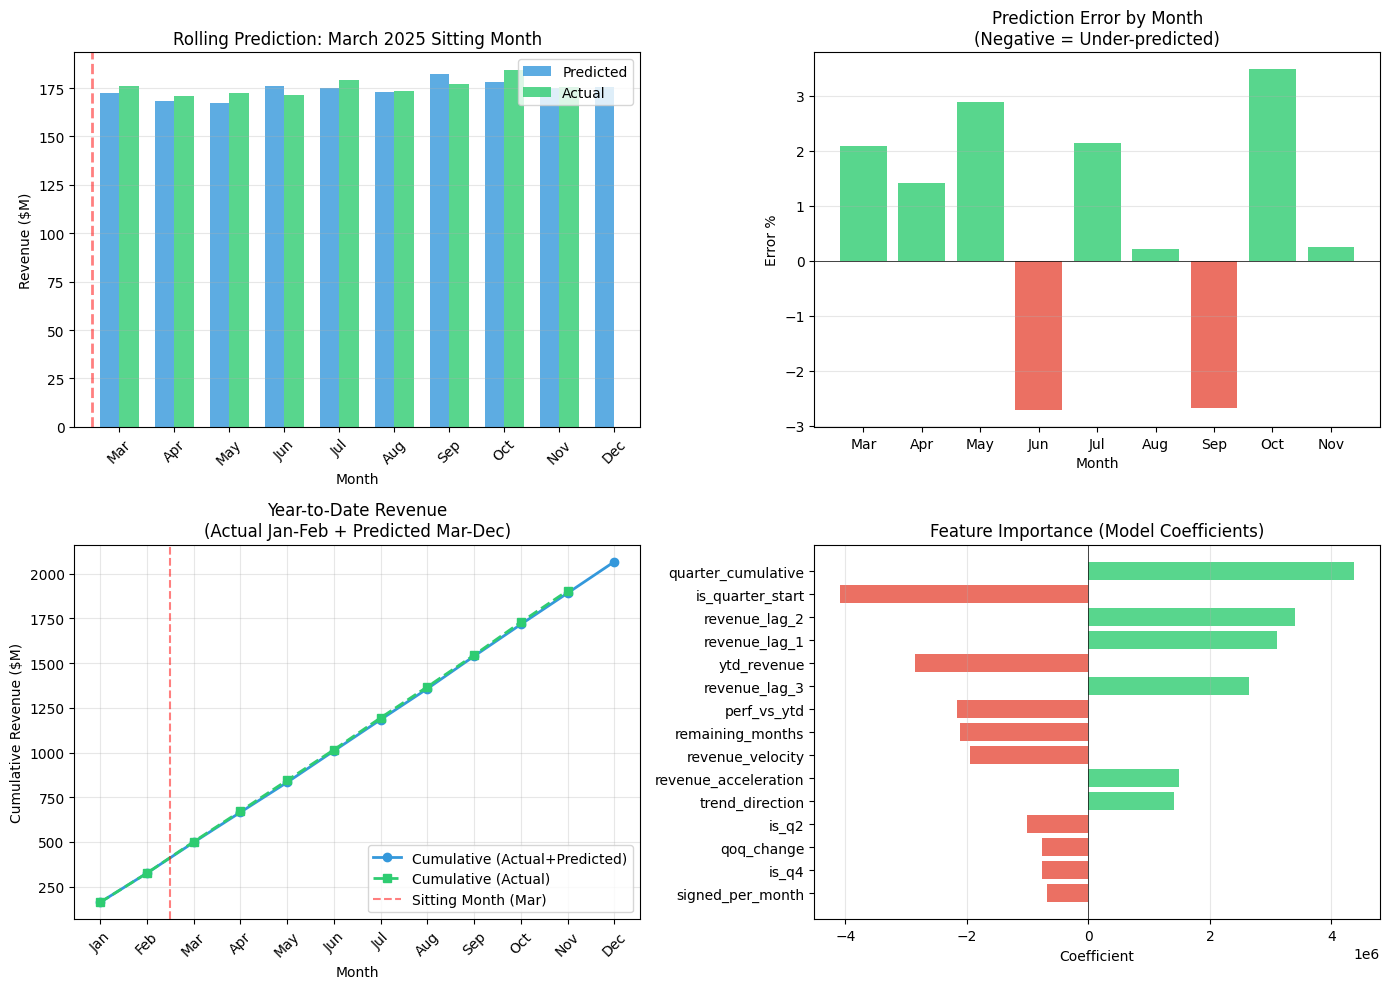


Chart saved as 'rolling_prediction_march_2025.png'


In [14]:
# =============================================================================
# STEP 8: VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot 1: Predicted vs Actual
ax1 = axes[0, 0]
months = results_march['month_num'].values
preds = results_march['predicted'].values / 1e6
acts = [r['actual'] / 1e6 if r['has_actual'] else np.nan for _, r in results_march.iterrows()]

x = np.arange(len(months))
width = 0.35
ax1.bar(x - width/2, preds, width, label='Predicted', color='#3498db', alpha=0.8)
ax1.bar(x + width/2, acts, width, label='Actual', color='#2ecc71', alpha=0.8)
ax1.axvline(x=-0.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue ($M)')
ax1.set_title('Rolling Prediction: March 2025 Sitting Month')
ax1.set_xticks(x)
ax1.set_xticklabels([month_names[m-1] for m in months], rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Error Percentage
ax2 = axes[0, 1]
actual_rows = results_march[results_march['has_actual']]
if len(actual_rows) > 0:
    err_months = actual_rows['month_num'].values
    errors = actual_rows['error_pct'].values
    colors = ['#e74c3c' if e < 0 else '#2ecc71' for e in errors]
    ax2.bar([month_names[m-1] for m in err_months], errors, color=colors, alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Error %')
    ax2.set_title('Prediction Error by Month\n(Negative = Under-predicted)')
    ax2.grid(axis='y', alpha=0.3)

# Plot 3: Cumulative Revenue
ax3 = axes[1, 0]
# Get Jan-Feb actual
jan_feb_mask = (df_features['year'] == 2025) & (df_features['month_num'].isin([1, 2]))
jan_feb_actual = df_features.loc[jan_feb_mask, 'actual_revenue'].values

# Build cumulative series
all_months = list(range(1, 13))
cumulative_pred = []
cumulative_act = []
running_pred = 0
running_act = 0

for m in all_months:
    if m < 3:
        # Jan, Feb - actual
        running_pred += jan_feb_actual[m-1] if m-1 < len(jan_feb_actual) else 0
        running_act += jan_feb_actual[m-1] if m-1 < len(jan_feb_actual) else 0
    else:
        # Mar-Dec - predicted
        running_pred += predictions_march.get(m, 0)
        row = results_march[results_march['month_num'] == m]
        if len(row) > 0 and row.iloc[0]['has_actual']:
            running_act += row.iloc[0]['actual']
        else:
            running_act = np.nan
    cumulative_pred.append(running_pred)
    cumulative_act.append(running_act)

ax3.plot(all_months, np.array(cumulative_pred)/1e6, 'o-', label='Cumulative (Actual+Predicted)', color='#3498db', linewidth=2)
ax3.plot(all_months, np.array(cumulative_act)/1e6, 's--', label='Cumulative (Actual)', color='#2ecc71', linewidth=2)
ax3.axvline(x=2.5, color='red', linestyle='--', alpha=0.5, label='Sitting Month (Mar)')
ax3.set_xlabel('Month')
ax3.set_ylabel('Cumulative Revenue ($M)')
ax3.set_title('Year-to-Date Revenue\n(Actual Jan-Feb + Predicted Mar-Dec)')
ax3.set_xticks(all_months)
ax3.set_xticklabels(month_names, rotation=45)
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Feature Importance
ax4 = axes[1, 1]
coef_df = pd.DataFrame({'Feature': FINAL_FEATURES, 'Coefficient': model.coef_})
coef_df['Abs_Coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coef', ascending=True)
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in coef_df['Coefficient']]
ax4.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.8)
ax4.set_xlabel('Coefficient')
ax4.set_title('Feature Importance (Model Coefficients)')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('rolling_prediction_march_2025.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nChart saved as 'rolling_prediction_march_2025.png'")

---
## STEP 9: Export Pipeline Configuration

This section exports all the configuration needed to run the pipeline in production.

In [15]:
# =============================================================================
# STEP 9: PIPELINE CONFIGURATION EXPORT
# =============================================================================
# This contains all the configuration needed for the training pipeline

print("="*80)
print("PIPELINE CONFIGURATION")
print("="*80)

print("\n# Copy these for your pipeline:\n")

print("# 1. FINAL FEATURES (required for prediction)")
print(f"FINAL_FEATURES = {FINAL_FEATURES}")

print("\n# 2. FEATURE MEDIANS (for missing value imputation)")
print("FEATURE_MEDIANS = {")
for feat in FINAL_FEATURES:
    print(f"    '{feat}': {FEATURE_MEDIANS[feat]:.2f},")
print("}")

print("\n# 3. MODEL PARAMETERS")
print(f"MODEL_TYPE = 'RidgeCV'")
print(f"MODEL_ALPHA = {model.alpha_:.4f}")

print("\n# 4. SCALER PARAMETERS")
print(f"SCALER_MEAN = {scaler.mean_.tolist()}")
print(f"SCALER_SCALE = {scaler.scale_.tolist()}")

print("\n" + "="*80)

PIPELINE CONFIGURATION

# Copy these for your pipeline:

# 1. FINAL FEATURES (required for prediction)
FINAL_FEATURES = ['ytd_revenue', 'remaining_months', 'quarter_cumulative', 'perf_vs_ytd', 'is_quarter_start', 'revenue_lag_1', 'revenue_velocity', 'revenue_lag_2', 'revenue_acceleration', 'signed_per_month', 'qoq_change', 'is_q2', 'trend_direction', 'revenue_lag_3', 'is_q4']

# 2. FEATURE MEDIANS (for missing value imputation)
FEATURE_MEDIANS = {
    'ytd_revenue': 815067203.93,
    'remaining_months': 6.00,
    'quarter_cumulative': 273894779.14,
    'perf_vs_ytd': 0.07,
    'is_quarter_start': 0.00,
    'revenue_lag_1': 143652715.03,
    'revenue_velocity': 2535776.74,
    'revenue_lag_2': 143138872.49,
    'revenue_acceleration': -748910.05,
    'signed_per_month': 112603788.71,
    'qoq_change': 0.02,
    'is_q2': 0.00,
    'trend_direction': 1.00,
    'revenue_lag_3': 142625029.96,
    'is_q4': 0.00,
}

# 3. MODEL PARAMETERS
MODEL_TYPE = 'RidgeCV'
MODEL_ALPHA = 1.3257

# 4. SCALE

In [16]:
# =============================================================================
# STEP 9B: FINAL SUMMARY
# =============================================================================

print("\n" + "#"*80)
print("# FINAL SUMMARY")
print("#"*80)

print(f"\n1. SITTING MONTH: March 2025")
print(f"   - Actual data available: Jan-Feb 2025")
print(f"   - Predictions made: Mar-Dec 2025")

print(f"\n2. MODEL: RidgeCV (alpha={model.alpha_:.2f})")
print(f"   - Training data: 2023-2024 ({len(train_df)} samples)")
print(f"   - Features used: {len(FINAL_FEATURES)}")

if len(actual_rows) > 0:
    print(f"\n3. METRICS (MAPE/MAE/RMSE):")
    print(f"   - MAPE: {mape:.2f}%")
    print(f"   - MAE:  ${mae:,.0f}")
    print(f"   - RMSE: ${rmse:,.0f}")

print(f"\n4. YEAR-END REVENUE FORECAST (2025):")
print(f"   - Actual (Jan-Feb):     ${df_features[(df_features['year']==2025) & (df_features['month_num']<3)]['actual_revenue'].sum():,.0f}")
print(f"   - Predicted (Mar-Dec):  ${sum(predictions_march.values()):,.0f}")
print(f"   - TOTAL YEAR-END:       ${year_end_march:,.0f}")

print(f"\n5. FINAL FEATURES FOR PIPELINE:")
for i, feat in enumerate(FINAL_FEATURES, 1):
    print(f"   {i:2d}. {feat}")

print("\n" + "#"*80)


################################################################################
# FINAL SUMMARY
################################################################################

1. SITTING MONTH: March 2025
   - Actual data available: Jan-Feb 2025
   - Predictions made: Mar-Dec 2025

2. MODEL: RidgeCV (alpha=1.33)
   - Training data: 2023-2024 (22 samples)
   - Features used: 15

3. METRICS (MAPE/MAE/RMSE):
   - MAPE: 1.98%
   - MAE:  $3,498,976
   - RMSE: $4,005,432

4. YEAR-END REVENUE FORECAST (2025):
   - Actual (Jan-Feb):     $325,094,076
   - Predicted (Mar-Dec):  $1,742,754,002
   - TOTAL YEAR-END:       $2,067,848,078

5. FINAL FEATURES FOR PIPELINE:
    1. ytd_revenue
    2. remaining_months
    3. quarter_cumulative
    4. perf_vs_ytd
    5. is_quarter_start
    6. revenue_lag_1
    7. revenue_velocity
    8. revenue_lag_2
    9. revenue_acceleration
   10. signed_per_month
   11. qoq_change
   12. is_q2
   13. trend_direction
   14. revenue_lag_3
   15. is_q4

############

---
## APPENDIX: Other Sitting Months (Commented Out)

Uncomment below to test predictions from other sitting months.

In [18]:
# =============================================================================
# APPENDIX: OTHER SITTING MONTHS (COMMENTED OUT)
# =============================================================================
# Uncomment to test predictions from other sitting months

# # April 2025 Sitting Month
# # -------------------------
# # results_april, df_april, predictions_april, year_end_april = rolling_predict(
# #     df_features=df_features,
# #     model=model,
# #     scaler=scaler,
# #     feature_list=FINAL_FEATURES,
# #     feature_medians=FEATURE_MEDIANS,
# #     sitting_year=2025,
# #     sitting_month=4,
# #     include_december=True
# # )

# # July 2025 Sitting Month (Mid-Year)
# # -----------------------------------
# results_july, df_july, predictions_july, year_end_july = rolling_predict(
#     df_features=df_features,
#     model=model,
#     scaler=scaler,
#     feature_list=FINAL_FEATURES,
#     feature_medians=FEATURE_MEDIANS,
#     sitting_year=2025,
#     sitting_month=7,
#     include_december=True
# )

# print("Other sitting month examples are commented out.")
# print("Uncomment above to test April or July sitting months.")